# Person Re-ID with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.datasets.reid import TripletDataGenerator, TestingDataGenerator
from vbranch.applications.cnn import SimpleCNNLarge
from vbranch.applications.resnet import ResNet50
from vbranch.applications.densenet import DenseNet121
from vbranch.callbacks import reid_acc
from vbranch.losses import triplet

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data_iterator_from_generator as get_iterator
from vbranch.utils.training import lr_exp_decay_scheduler, beta1_scheduler

Using TensorFlow backend.


In [3]:
SAVE = True
MODEL_ID = 1
ARCHITECTURE = 'densenet'
DATASET = 'market'
NUM_BRANCHES = 2
SHARED_FRAC = 0.

EPOCHS = 250
STEPS_PER_EPOCH = 100
T_0 = 150
OUTPUT_DIM = 128
# IMG_DIM = (256, 128, 3)
IMG_DIM = (128, 64, 3)

In [4]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}-dim{}_{:d}'.format(DATASET, ARCHITECTURE, IMG_DIM[0], MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}-dim{}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, IMG_DIM[0], MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/vb-market-densenet-B2-S0.00-dim128_1


## Load Data

In [5]:
P, K = 18, 4
train_generator = TripletDataGenerator(DATASET, 'train', 
                                       P=P, K=K,
                                       preprocess=ARCHITECTURE, 
                                       img_dim=IMG_DIM)

TripletDataGenerator CONFIG
Dataset:	 market
Split:		 train
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Flatten:	 True
Labels:		 False


In [6]:
batch = train_generator.sample(4, 4, flatten=False, 
                             preprocess=ARCHITECTURE, 
                             img_dim=IMG_DIM)
# for i in range(4):
#     for j in range(4):
#         plt.subplot(4, 4, 4*i+j+1)
#         plt.imshow(batch[i, j].squeeze(), cmap=plt.cm.gray)
#         plt.axis('off')
# plt.show()

In [7]:
batch.min(), batch.max()

(-2.117904, 2.64)

## Build Model

In [8]:
inputs, train_init_op, test_init_op = get_iterator(train_generator, (None,)+IMG_DIM, n=NUM_BRANCHES)
print(inputs)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.
[<tf.Tensor 'input_1:0' shape=(?, 128, 64, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 128, 64, 3) dtype=float32>]


In [9]:
lr = tf.placeholder('float32', name='lr')
beta1 = tf.placeholder('float32', shape=[], name='beta1')
lr_scheduler = lr_exp_decay_scheduler(0.0003, T_0, EPOCHS, 0.001, warm_up=20)
beta1_sched = beta1_scheduler(T_0)

name = 'model'

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, 
                               shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'resnet':
        model, assign_ops = ResNet50(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
    elif ARCHITECTURE == 'densenet':
        model, assign_ops = DenseNet121(inputs, OUTPUT_DIM, name=name, 
                                     shared_frac=SHARED_FRAC, 
                                     weights='imagenet')
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=beta1)

    # Compile model
    model.compile(optimizer, triplet(P,K, margin='soft'), 
                  train_init_op, test_init_op, 
                  callbacks={'acc' : reid_acc(DATASET, NUM_BRANCHES, 
                                              preprocess=ARCHITECTURE, 
                                              buffer=1000, img_dim=IMG_DIM)},
                  schedulers={'lr:0': lr_scheduler, 'beta1:0':beta1_sched},  
                  assign_ops=assign_ops)

Loading weights for DenseNet121...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
model.summary()

i    Layer name                      Output shape      Num param  Inbound               
----------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                    
----------------------------------------------------------------------------------------
     Input                           [None,128,64,3]                                    
----------------------------------------------------------------------------------------
0    zero_pad (ZeroPadding2D)        [None,134,70,3]   0          input                 
                                     [None,134,70,3]                                    
----------------------------------------------------------------------------------------
1    conv1/conv (Conv2D)             [None,64,32,64]   18816      zero_pad              
                                     [None,64,32,64]                                    
---------------------

In [11]:
print(model.output)

[<tf.Tensor 'model/output/vb1/output:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'model/output/vb2/output:0' shape=(?, 128) dtype=float32>]


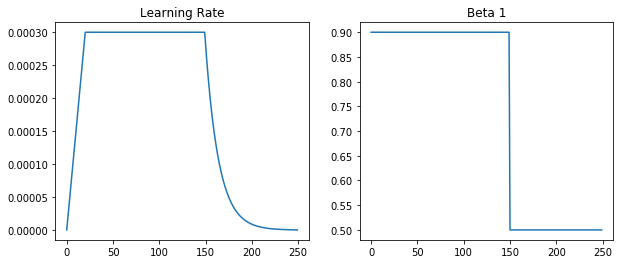

In [12]:
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
beta1_steps = [beta1_sched(e + 1) for e in range(EPOCHS)]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lr_steps)
plt.title('Learning Rate')

plt.subplot(1,2,2)
plt.plot(beta1_steps)
plt.title('Beta 1')

plt.show()

In [13]:
lr_steps[149]

0.0003

In [14]:
history = model.fit(EPOCHS, STEPS_PER_EPOCH, log_path=model_path if SAVE else None, 
                    call_step=10, verbose=1)

Epoch 1/250
100/100 [==============================] - 87s 875ms/step - lr:0: 3.0000e-07 - beta1:0: 0.9000 - loss_1: 2629.1458 - loss_2: 2562.4530
Epoch 2/250
100/100 [==============================] - 43s 435ms/step - lr:0: 1.5285e-05 - beta1:0: 0.9000 - loss_1: 2035.9478 - loss_2: 2009.8076
Epoch 3/250
100/100 [==============================] - 43s 429ms/step - lr:0: 3.0270e-05 - beta1:0: 0.9000 - loss_1: 1569.7288 - loss_2: 1554.6308
Epoch 4/250
100/100 [==============================] - 43s 432ms/step - lr:0: 4.5255e-05 - beta1:0: 0.9000 - loss_1: 1317.5525 - loss_2: 1318.2535
Epoch 5/250
100/100 [==============================] - 43s 432ms/step - lr:0: 6.0240e-05 - beta1:0: 0.9000 - loss_1: 1079.9543 - loss_2: 1085.4635
Epoch 6/250
100/100 [==============================] - 44s 442ms/step - lr:0: 7.5225e-05 - beta1:0: 0.9000 - loss_1: 876.0519 - loss_2: 853.6925
Epoch 7/250
100/100 [==============================] - 44s 438ms/step - lr:0: 9.0210e-05 - beta1:0: 0.9000 - loss_1: 709

100/100 [==============================] - 44s 439ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 33.1853 - loss_2: 40.7003
Epoch 40/250
 99/100 [============================>.] - ETA: 0s - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 36.6662 - loss_2: 34.1114TestingDataGenerator CONFIG
Dataset:	 market
Split:		 test
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 995
TestingDataGenerator CONFIG
Dataset:	 market
Split:		 query
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 842
Computing gallery embeddings...
15913/15913 [==============================] - 40s 3ms/step
Computing query embeddings...
3368/3368 [==============================] - 8s 3ms/step
Elapsed time: 20.047404766082764
Elapsed time: 20.065765857696533
Elapsed time: 35.59265851974487
100/100 [==============================] - 168s 2s/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 36.3330 - loss_2: 33.7707 - mAP_1: 0.4628 - rank1_1: 0.674

100/100 [==============================] - 43s 430ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 35.7663 - loss_2: 28.3612
Epoch 72/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 32.3510 - loss_2: 26.8891
Epoch 73/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 33.9842 - loss_2: 32.2086
Epoch 74/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 27.6228 - loss_2: 21.4616
Epoch 75/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 35.8249 - loss_2: 24.7626
Epoch 76/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 31.9800 - loss_2: 20.0481
Epoch 77/250
100/100 [==============================] - 43s 432ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 30.4391 - loss_2: 21.4096
Epoch

100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 23.2916 - loss_2: 18.3409
Epoch 110/250
 99/100 [============================>.] - ETA: 0s - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 27.9180 - loss_2: 15.5751TestingDataGenerator CONFIG
Dataset:	 market
Split:		 test
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 995
TestingDataGenerator CONFIG
Dataset:	 market
Split:		 query
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 842
Computing gallery embeddings...
15913/15913 [==============================] - 40s 3ms/step
Computing query embeddings...
3368/3368 [==============================] - 8s 3ms/step
Elapsed time: 19.67814016342163
Elapsed time: 21.238718509674072
Elapsed time: 36.03971290588379
100/100 [==============================] - 169s 2s/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 27.8091 - loss_2: 15.4324 - mAP_1: 0.5127 - rank1_1: 0.711

100/100 [==============================] - 43s 429ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 11.7555 - loss_2: 17.6575
Epoch 142/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 10.9326 - loss_2: 20.2592
Epoch 143/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 15.0974 - loss_2: 14.5278
Epoch 144/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 16.2624 - loss_2: 12.1254
Epoch 145/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 24.6178 - loss_2: 18.2020
Epoch 146/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 20.5225 - loss_2: 17.7845
Epoch 147/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.0000e-04 - beta1:0: 0.9000 - loss_1: 18.6863 - loss_2: 16.7684

 99/100 [============================>.] - ETA: 0s - lr:0: 3.7768e-05 - beta1:0: 0.5000 - loss_1: 0.8949 - loss_2: 2.0576TestingDataGenerator CONFIG
Dataset:	 market
Split:		 test
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 995
TestingDataGenerator CONFIG
Dataset:	 market
Split:		 query
Preprocess:	 densenet
Dimension:	 (128, 64, 3)
Crop:		 False
Flip:		 True
Buffer:		 842
Computing gallery embeddings...
15913/15913 [==============================] - 39s 2ms/step
Computing query embeddings...
3368/3368 [==============================] - 8s 2ms/step
Elapsed time: 19.793011903762817
Elapsed time: 19.851835012435913
Elapsed time: 36.92305946350098
100/100 [==============================] - 168s 2s/step - lr:0: 3.7768e-05 - beta1:0: 0.5000 - loss_1: 0.8860 - loss_2: 2.0370 - mAP_1: 0.6173 - rank1_1: 0.7925 - rank5_1: 0.9127 - mAP_2: 0.6175 - rank1_2: 0.8002 - rank5_2: 0.9195 - mAP_ensemble: 0.6722 - rank1_ensemble: 0.8367 - rank5_ensemble: 0.9371
Epo

100/100 [==============================] - 43s 431ms/step - lr:0: 3.8647e-06 - beta1:0: 0.5000 - loss_1: 0.4602 - loss_2: 1.6986
Epoch 214/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.6068e-06 - beta1:0: 0.5000 - loss_1: 0.7271 - loss_2: 1.1071
Epoch 215/250
100/100 [==============================] - 43s 431ms/step - lr:0: 3.3661e-06 - beta1:0: 0.5000 - loss_1: 0.4448 - loss_2: 0.5954
Epoch 216/250
100/100 [==============================] - 43s 432ms/step - lr:0: 3.1414e-06 - beta1:0: 0.5000 - loss_1: 0.4524 - loss_2: 0.2051
Epoch 217/250
100/100 [==============================] - 43s 431ms/step - lr:0: 2.9317e-06 - beta1:0: 0.5000 - loss_1: 0.8387 - loss_2: 0.6908
Epoch 218/250
100/100 [==============================] - 43s 431ms/step - lr:0: 2.7360e-06 - beta1:0: 0.5000 - loss_1: 0.5691 - loss_2: 1.2058
Epoch 219/250
100/100 [==============================] - 43s 431ms/step - lr:0: 2.5534e-06 - beta1:0: 0.5000 - loss_1: 1.1599 - loss_2: 0.4437
Epoch 220/250

15913/15913 [==============================] - 40s 3ms/step
Computing query embeddings...
3368/3368 [==============================] - 8s 3ms/step
Elapsed time: 20.061033010482788
Elapsed time: 20.079084396362305
Elapsed time: 37.735352754592896
100/100 [==============================] - 170s 2s/step - lr:0: 3.0000e-07 - beta1:0: 0.5000 - loss_1: 0.6665 - loss_2: 1.3157 - mAP_1: 0.6326 - rank1_1: 0.8017 - rank5_1: 0.9186 - mAP_2: 0.6275 - rank1_2: 0.8026 - rank5_2: 0.9240 - mAP_ensemble: 0.6815 - rank1_ensemble: 0.8373 - rank5_ensemble: 0.9365


## Evaluation

In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=False)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 95s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 21s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 18.550950050354004
{'mAP': 0.6934945495051927, 'rank1': 0.8423397, 'rank5': 0.9403207}


In [4]:
with TFSessionGrow() as sess:
    restore_sess(sess, 'models/market-densenet-dim256_1/')
    print(reid_acc(DATASET, NUM_BRANCHES, preprocess=ARCHITECTURE,
                   buffer=1000, img_dim=IMG_DIM, crop=True)(sess))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/market-densenet-dim256_1/ckpt
995 15913
842 3368
Computing gallery embeddings...
15913/15913 [==============================] - 97s 6ms/step
Computing query embeddings...
3368/3368 [==============================] - 22s 6ms/step
Started process...
Started process...
Started process...
Started process...
Elapsed time: 33.23809599876404
{'mAP': 0.6466024319270626, 'rank1': 0.8111639, 'rank5': 0.9275534}
